# Deploy and Distribute TensorFlow

In this notebook you will learn how to deploy TensorFlow models to TensorFlow Serving (TFS), using the REST API or the gRPC API, and how to train a model across multiple devices.

## Imports

In [1]:
%matplotlib inline

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sklearn
import sys
import tensorflow as tf
from tensorflow import keras
import time

In [3]:
print("python", sys.version)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

python 3.6.8 |Anaconda, Inc.| (default, Dec 30 2018, 01:22:34) 
[GCC 7.3.0]
matplotlib 3.0.2
numpy 1.15.4
pandas 0.23.4
sklearn 0.20.1
tensorflow 2.0.0-dev20190304
tensorflow.python.keras.api._v2.keras 2.2.4-tf


In [4]:
assert sys.version_info >= (3, 5) # Python ≥3.5 required
assert tf.__version__ >= "2.0"    # TensorFlow ≥2.0 required

![Exercise](https://c1.staticflickr.com/9/8101/8553474140_c50cf08708_b.jpg)

## Exercise 1 – Deploying a Model to TensorFlow Serving

## Save/Load a `SavedModel`

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.
X_test = X_test / 255.
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd",
              metrics=["accuracy"])
model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

In [ ]:
MODEL_NAME = "my_fashion_mnist"
!rm -rf {MODEL_NAME}

In [ ]:
import time

model_version = int(time.time())
model_path = os.path.join(MODEL_NAME, str(model_version))
os.makedirs(model_path)

In [ ]:
tf.saved_model.save(model, model_path)

In [ ]:
for root, dirs, files in os.walk(MODEL_NAME):
    indent = '    ' * root.count(os.sep)
    print('{}{}/'.format(indent, os.path.basename(root)))
    for filename in files:
        print('{}{}'.format(indent + '    ', filename))

In [ ]:
!saved_model_cli show --dir {model_path}

In [ ]:
!saved_model_cli show --dir {model_path} --tag_set serve

In [ ]:
!saved_model_cli show --dir {model_path} --tag_set serve \
                      --signature_def serving_default

In [ ]:
!saved_model_cli show --dir {model_path} --all

**Warning**: as you can see, the method name is empty. This is [a bug](https://github.com/tensorflow/tensorflow/issues/25235), hopefully it will be fixed shortly. In the meantime, you must use `keras.experimental.export()` instead of `tf.saved_model.save()`:

In [ ]:
!rm -rf {MODEL_NAME}
model_path = keras.experimental.export(model, MODEL_NAME).decode("utf-8")
!saved_model_cli show --dir {model_path} --all

Let's write a few test instances to a `npy` file so we can pass them easily to our model:

In [ ]:
X_new = X_test[:3]
np.save("my_fashion_mnist_tests.npy", X_new, allow_pickle=False)

In [ ]:
input_name = model.input_names[0]
input_name

And now let's use `saved_model_cli` to make predictions for the instances we just saved:

In [ ]:
!saved_model_cli run --dir {model_path} --tag_set serve \
                     --signature_def serving_default    \
                     --inputs {input_name}=my_fashion_mnist_tests.npy

## TensorFlow Serving

Install [Docker](https://docs.docker.com/install/) if you don't have it already. Then run:

```bash
docker pull tensorflow/serving

docker run -it --rm -p 8501:8501 \
   -v "`pwd`/my_fashion_mnist:/models/my_fashion_mnist" \
   -e MODEL_NAME=my_fashion_mnist \
   tensorflow/serving
```

Once you are finished using it, press Ctrl-C to shut down the server.

In [ ]:
import json

input_data_json = json.dumps({
    "signature_name": "serving_default",
    "instances": X_new.tolist(),
})
print(input_data_json[:200] + "..." + input_data_json[-200:])

Now let's use TensorFlow Serving's REST API to make predictions:

In [ ]:
import requests

SERVER_URL = 'http://localhost:8501/v1/models/my_fashion_mnist:predict'
            
response = requests.post(SERVER_URL, data=input_data_json)
response.raise_for_status()
response = response.json()

In [ ]:
response.keys()

In [ ]:
y_proba = np.array(response["predictions"])
y_proba.round(2)

### Using Serialized Examples

In [ ]:
serialized = []
for image in X_new:
    image_data = tf.train.FloatList(value=image.ravel())
    features = tf.train.Features(
        feature={
            "image": tf.train.Feature(float_list=image_data),
        }
    )
    example = tf.train.Example(features=features)
    serialized.append(example.SerializeToString())

In [ ]:
[data[:100]+b'...' for data in serialized]

In [ ]:
def parse_images(serialized):
    expected_features = {
        "image": tf.io.FixedLenFeature([28 * 28], dtype=tf.float32)
    }
    examples = tf.io.parse_example(serialized, expected_features)
    return tf.reshape(examples["image"], (-1, 28, 28))

In [ ]:
parse_images(serialized)

In [ ]:
serialized_inputs = keras.layers.Input(shape=[], dtype=tf.string)
images = keras.layers.Lambda(lambda serialized: parse_images(serialized))(serialized_inputs)
y_proba = model(images)
ser_model = keras.models.Model(inputs=[serialized_inputs], outputs=[y_proba])

In [ ]:
SER_MODEL_NAME = "my_ser_fashion_mnist"
!rm -rf {SER_MODEL_NAME}
ser_model_path = keras.experimental.export(ser_model, SER_MODEL_NAME).decode("utf-8")
!saved_model_cli show --dir {ser_model_path} --all

```bash
docker run -it --rm -p 8500:8500 -p 8501:8501 \
   -v "`pwd`/my_ser_fashion_mnist:/models/my_ser_fashion_mnist" \
   -e MODEL_NAME=my_ser_fashion_mnist \
   tensorflow/serving
```

In [ ]:
import base64
import json

ser_input_data_json = json.dumps({
    "signature_name": "serving_default",
    "instances": [{"b64": base64.b64encode(data).decode("utf-8")}
                  for data in serialized],
})
print(ser_input_data_json[:200] + "..." + ser_input_data_json[-200:])

In [ ]:
import requests

SER_SERVER_URL = 'http://localhost:8501/v1/models/my_ser_fashion_mnist:predict'
            
response = requests.post(SER_SERVER_URL, data=ser_input_data_json)
response.raise_for_status()
response = response.json()

In [ ]:
response.keys()

In [ ]:
y_proba = np.array(response["predictions"])
y_proba.round(2)

In [ ]:
!python3 -m pip install --no-deps tensorflow-serving-api

In [ ]:
import grpc
from tensorflow_serving.apis import predict_pb2
from tensorflow_serving.apis import prediction_service_pb2_grpc

channel = grpc.insecure_channel('localhost:8500')
predict_service = prediction_service_pb2_grpc.PredictionServiceStub(channel)

request = predict_pb2.PredictRequest()
request.model_spec.name = SER_MODEL_NAME
request.model_spec.signature_name = "serving_default"
input_name = ser_model.input_names[0]
request.inputs[input_name].CopyFrom(tf.compat.v1.make_tensor_proto(serialized))

result = predict_service.Predict(request, 10.0)

In [ ]:
result

In [ ]:
output_name = ser_model.output_names[0]
output_name

In [ ]:
shape = [dim.size for dim in result.outputs[output_name].tensor_shape.dim]
shape

In [ ]:
y_proba = np.array(result.outputs[output_name].float_val).reshape(shape)
y_proba.round(2)

![Exercise](https://c1.staticflickr.com/9/8101/8553474140_c50cf08708_b.jpg)

## Exercise 2 – Distributed Training

In [5]:
from tensorflow.core.protobuf import config_pb2
from tensorflow.python.client import session

gpu_options = config_pb2.GPUOptions(per_process_gpu_memory_fraction=0.4)
keras.backend.set_session(session.Session(config=config_pb2.ConfigProto(gpu_options=gpu_options)))

In [6]:
keras.backend.clear_session()

In [7]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

for d in device_lib.list_local_devices():
    print("{} - {}".format(d.device_type, d.name))

keras.backend.clear_session()

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 18163319579938050922
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 9103409778728912684
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_GPU:1"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 1569742237960792877
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 11078534915189928932
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6765622067
locality {
  bus_id: 1
  links {
    link {
      device_id: 1
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 433824853230804404
physical_device_desc: "device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0000:37:00.0, compute capability: 7.0"
, name: "/device:GPU:1"
device_type: "GPU

In [ ]:
?tf.distribute.MirroredStrategy

In [8]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()

In [ ]:
?tf.distribute.MirroredStrategy

In [9]:
distribution = tf.distribute.MirroredStrategy()

with distribution.scope():
    model = keras.models.Sequential(layers=
                                [keras.layers.Flatten(input_shape=[28, 28], name='input_flattter')] + \
                                [keras.layers.Dense(units=100, activation='selu', name=f"hidden_{n}")
                                 for n in range(10)] + \
                                [keras.layers.AlphaDropout(rate=0.5, name='dropout'),
                                 keras.layers.Dense(units=10, activation='softmax', name='output')]
    )
    
    model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd",
                  metrics=["accuracy"])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_flattter (Flatten)     (None, 784)               0         
_________________________________________________________________
hidden_0 (Dense)             (None, 100)               78500     
_________________________________________________________________
hidden_1 (Dense)             (None, 100)               10100     
_________________________________________________________________
hidden_2 (Dense)             (None, 100)               10100     
_________________________________________________________________
hidden_3 (Dense)             (None, 100)               10100     
_________________________________________________________________
hidden_4 (Dense)             (None, 100)               10100     
_________________________________________________________________
hidden_5 (Dense)             (None, 100)               1

In [10]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [12]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
X_valid_scaled = scaler.transform(X_valid.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
X_test_scaled = scaler.transform(X_test.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)

In [13]:
print(X_train_scaled.shape)
print(X_valid_scaled.shape)
print(X_test_scaled.shape)

(55000, 28, 28)
(5000, 28, 28)
(10000, 28, 28)


In [ ]:
?model.fit

In [14]:
# steps_per_epoch=100, batch_size=20, \

%time history = model.fit(X_train_scaled, y_train, \
                          validation_data=(X_valid_scaled, y_valid), \
                          epochs=100, batch_size=50, \
                          callbacks=[keras.callbacks.EarlyStopping(patience=5)])

W0304 13:01:48.149888 140435102033728 distributed_training_utils.py:182] Your input callback is not one of the predefined Callbacks that supports DistributionStrategy. You might encounter an error if you access one of the model's attributes as part of the callback since these attributes are not set. You can access each of the individual distributed models using the `_grouped_model` attribute of your original model.


Epoch 1/100
1100/1100 [==============================] - 16s 15ms/step - loss: 1.4409 - accuracy: 0.4975 - val_loss: 0.7639 - val_accuracy: 0.7628
Epoch 2/100
1100/1100 [==============================] - 5s 4ms/step - loss: 0.8577 - accuracy: 0.7022 - val_loss: 0.7094 - val_accuracy: 0.7986
Epoch 3/100
1100/1100 [==============================] - 5s 4ms/step - loss: 0.7118 - accuracy: 0.7552 - val_loss: 0.6919 - val_accuracy: 0.8198
Epoch 4/100
1100/1100 [==============================] - 5s 4ms/step - loss: 0.6398 - accuracy: 0.7824 - val_loss: 0.6613 - val_accuracy: 0.8272
Epoch 5/100
1100/1100 [==============================] - 5s 4ms/step - loss: 0.5932 - accuracy: 0.7983 - val_loss: 0.6386 - val_accuracy: 0.8360
Epoch 6/100
1100/1100 [==============================] - 5s 4ms/step - loss: 0.5566 - accuracy: 0.8106 - val_loss: 0.6332 - val_accuracy: 0.8410
Epoch 7/100
1100/1100 [==============================] - 5s 4ms/step - loss: 0.5307 - accuracy: 0.8201 - val_loss: 0.6136 - val_

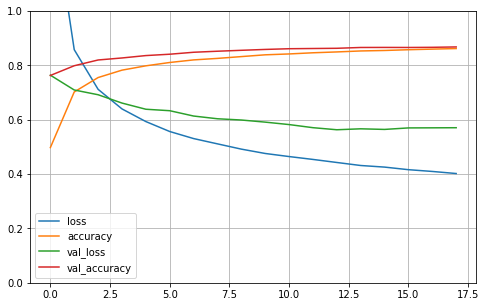

In [15]:
plot_learning_curves(history)

In [16]:
model.evaluate(X_test_scaled, y_test, batch_size=50)

200/200 [==============================] - 0s 2ms/step - loss: 0.6549 - accuracy: 0.8523


[0.6548583793267607, 0.8523]